In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import numpy.linalg as npl
from scipy.optimize import minimize
from process_results import process_results, aggregate_results, best_ridge

%matplotlib inline
%load_ext autoreload
%autoreload 2

save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)

In [4]:
class p:
    seed = 15
    out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/double_descent/test'
    dset = 'gaussian' # gaussian
    beta_type = 'gaussian' # one_hot
    beta_norm = 1
    iid = 'iid' # 'iid', 'clustered', 'spike', decay, mult_decay
    dset_num = 1 # only matters for pmlb
    dset_name = ''
    reg_param = -1.0 # -1 use csv
    num_features = 100
    n_train_over_num_features = 3 # this and num_features sets n_train
    n_test = 100
    noise_std = 1
    noise_distr = 'gaussian' # gaussian, t, gaussian_scale_var, thresh
    model_type = 'ridge' # mdl_orig, 
    cov_param = 2

# vary lambda

3it [00:02,  1.05s/it]/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
5it [00:04,  1.19it/s]


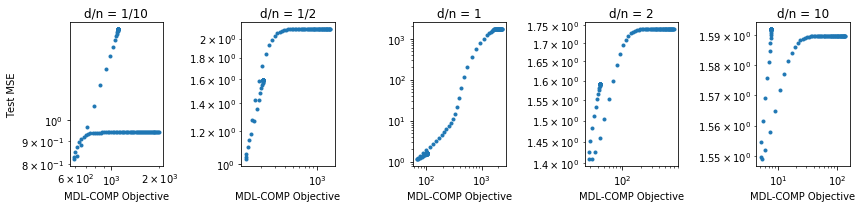

In [5]:
R, C = 1, 5
plt.figure(figsize=(12, 3))
tits = ['1/10', '1/2', '1', '2', '10']
for c, n_train_over_num_features in tqdm(enumerate([10, 2, 1, 1/2, 1/10])):
    p.n_train_over_num_features = n_train_over_num_features
    
    # warning - this reseeds!
    p.n_train = int(p.n_train_over_num_features * p.num_features)
    X_train, y_train, X_test, y_test, betastar = \
        data.get_data_train_test(n_train=p.n_train, n_test=p.n_test, p=p.num_features, 
                            noise_std=p.noise_std, noise_distr=p.noise_distr, iid=p.iid, # parameters to be determined
                            beta_type=p.beta_type, beta_norm=p.beta_norm, 
                            seed_for_training_data=p.seed, cov_param=p.cov_param)

    eigenvals, eigenvecs = npl.eig(X_train.T @ X_train)
    var = p.noise_std**2

    def calc_thetahat(l):
        inv = npl.pinv(X_train.T @ X_train + l * np.eye(p.num_features))
        return inv @ X_train.T @ y_train

    def mdl1_loss(l):
        thetahat = calc_thetahat(l)
        mse_norm = npl.norm(y_train - X_train @ thetahat)**2 / (2 * var)
        theta_norm = npl.norm(thetahat)**2 / (2 * var)
        eigensum = 0.5 * np.sum(np.log((eigenvals + l) / l))
        return mse_norm + theta_norm + eigensum


    lambdas = np.logspace(-10, 10, num=100)
    n = lambdas.size


    r = {
        'l': lambdas,
        'mdl1': np.zeros(n),
        'test_mse': np.zeros(n)
    }
    for i, l in enumerate(lambdas):
        thetahat = calc_thetahat(l)
        r['test_mse'][i] = np.mean(np.square(y_test - X_test @ thetahat))
        r['mdl1'][i] = mdl1_loss(l)
    plt.subplot(R, C, c + 1)
    plt.plot(r['mdl1'], r['test_mse'], '.')
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    if c == 0:
        plt.ylabel('Test MSE')
    plt.xlabel('MDL-COMP Objective')
    plt.title('d/n = ' + tits[c])
plt.savefig(oj(save_dir, 'fig_lambda.pdf'))